# Training with experimental data

Here we demonstrate the training with the actual data from the viscoelastic board experiment (Data_ExperimentDynVisSurf.txt).
We also estimate the uncertainty of the training results by the bootstrap method.
Note that since the details of the code depend on the setup being considered, appropriate modifications should be made when one wants to apply this code to other problems.
This file is structured as follows：


*   Loading the experimental data
*   Training and the outputs of the results

## Loading experimental data

Enter the path to the data and load it to prepare the training data.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt


df = pd.read_csv("Data_ExperimentDynVisSurf.txt", sep='\s+')
pd.set_option('display.max_columns', 50)
df=df.dropna(axis=1)

# Define the dimensionless variables (Similarity parameters of the first kind)
df['Pi'] = df.loc[:,'delta(mm)'] / df.loc[:,'R(mm)']
df['eta'] = df.loc[:,'rho'] * df.loc[:,'V_bc(mm/s)'] ** 2 / df.loc[:,'E']
df['kappa'] = df.loc[:,'h'] / df.loc[:,'R(mm)']
df['theta'] = df.loc[:,'mu'] / df.loc[:,'E'] ** (0.5) / df.loc[:,'rho'] ** (0.5) / df.loc[:,'R(mm)']
df['Psi'] =  df.loc[:,'Pi'] ** 3 / (df.loc[:,'kappa'] * df.loc[:,'eta'])

# Define the log of the previous variables
df['log_Pi'] = np.log(df['Pi'])
df['log_eta'] = np.log(df['eta'])
df['log_kappa'] = np.log(df['kappa'])
df['log_theta'] = np.log(df['theta'])
df['log_Psi'] = np.log(df['Psi'])

# Define the training data
x_ex_data = torch.Tensor( np.transpose( np.array([df['log_Pi'].to_numpy(), df['log_kappa'].to_numpy(), df['log_eta'].to_numpy(), df['log_theta'].to_numpy()]) ))
z_ex_data = torch.Tensor( df['log_Psi'].to_numpy() )

## Traning module

This section prepares the necessary modules for training.
The magnitude of the regularization term added to the loss function is set as $\lambda = 0.5$ by hand.

In [ ]:
class NNfuncfit_one_var_experiment(nn.Module):
    def __init__(self):
        super(NNfuncfit_one_var_experiment, self).__init__()
        self.layer1 = nn.Linear(4, 1)
        self.layer2 = nn.Linear(1, 10)
        self.layer3 = nn.Linear(10, 10)
        self.output_layer = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.output_layer(x)
        return x


# Function that performs training once with all experimental data and returns the learned (normalized) parameters
def single_learning_one_var_experiment(model, x_data, z_data, max_epoch, device):
    criterion = nn.MSELoss()
    opt = torch.optim.Adagrad(model.parameters(), lr=0.1)

    vec = torch.tensor([3, -1, -1, 0], dtype=torch.float32, device=device)

    losses = []
    losses_reg1 = []
    losses_reg2 = []

    for epoch in range(max_epoch):
        x, z = x_data.to(device), z_data.to(device)
        z = torch.reshape(z, (len(z), 1))
        y = model(x)

        # Create regularization terms (Choose the overall coefficients by hand)
        reg_term1 = 0.5 * (torch.norm(model.layer1.weight[0, :4])**2 - 1) ** 2
        reg_term2 = 0.5 * (vec @ model.layer1.weight[0, :4]) ** 2

        # Compute the loss function
        loss = criterion(y, z) + reg_term1 + reg_term2

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        losses_reg1.append(reg_term1.item())
        losses_reg2.append(reg_term2.item())

    parameters = list(model.parameters())[0].cpu().data.detach().numpy()[0]
    weights = parameters/(-parameters[3])
    normalized_weights = weights + (1 - weights[0])/3 * vec.cpu().numpy()

    print("(w)^2:", np.dot( parameters, parameters ) )
    print("(w dot vec)^2:", np.dot( parameters, vec.cpu().numpy() )**2 )

    print("final loss:", losses[-1])
    print("final reg1:", losses_reg1[-1])
    print("final reg2:", losses_reg2[-1])
    print("raw parameters:", parameters)

    plt.plot(losses, label=f'Sample')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return weights, normalized_weights


# Function that plots the training results with the training data
def plot_learned_functions(model, x_data, z_data, device, params):

    hor_vals = np.array([ np.dot(params, x) for x in x_data])
    z_nn = model(torch.Tensor(x_data).to(device))
    z_nn_vals = z_nn.cpu().detach().numpy()

    zip_lists = zip(hor_vals, z_data, z_nn_vals)
    zip_sort = sorted(zip_lists)
    hor_vals, z_data, z_nn_vals = zip(*zip_sort)

    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(hor_vals, z_data, label='Training data', color='cornflowerblue', marker="o", s=30)
    ax.plot(hor_vals, z_nn_vals, label='Neural network prediction', color='black', linewidth=1.5)
    ax.set_xlabel(r"$y$", size = "xx-large")
    ax.set_ylabel(r"$\psi$", labelpad=10, size = "xx-large", rotation = "horizontal")
    plt.legend(fontsize = 12, fancybox=False, edgecolor="black", borderpad=0.5, borderaxespad=0.8, handlelength=2, handletextpad=1)
    plt.tick_params(direction = "in", right=True, top=True, labelsize = 15)
    plt.tight_layout()
    fig.show()
    plt.savefig('1dim.pdf')


# Module that performs both training and plotting
def perform_single(x_data, z_data, max_epoch):

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = NNfuncfit_one_var_experiment().to(device)

    weights, normalized_weights = single_learning_one_var_experiment(model, x_data, z_data, max_epoch, device)

    print("ratio of parameters:")
    print(weights)
    print("Normalized parameters:")
    print(normalized_weights)

    plot_learned_functions(model, x_data, z_data, device, weights)

## Module for the bootstrap method

In [ ]:
# Resampling of the data
def bootstrap_sample(x_data, z_data, sample_size):
    indices = np.random.choice(len(x_data), size=sample_size, replace=True)
    x_sample = x_data[indices]
    z_sample = z_data[indices]
    return x_sample, z_sample


# Function that performs training once with resampled data and returns the learned (normalized) parameters
def bootstrap_learning_one_var_experiment(model, x_data, z_data, num_samples, max_epoch, device, loss_threshold):
    parameter_samples = []
    normalized_parameter_samples = []

    vec = torch.tensor([3, -1, -1, 0], dtype=torch.float32, device=device)

    i=0
    max_error=10
    error_cnt=0

    while i < num_samples:
        if error_cnt>max_error:
          print("Too many errors.")
          break

        criterion = nn.MSELoss()
        opt = torch.optim.Adagrad(model.parameters(), lr=0.1)

        x, z = bootstrap_sample(x_data, z_data, len(x_data))
        x, z = x.to(device), z.to(device)
        z = torch.reshape(z, (len(z), 1))

        losses = []
        for epoch in range(max_epoch):
            y = model(x)

             # Create regularization terms (Choose the overall coefficients by hand)
            reg_term1 = 0.5 * (torch.norm(model.layer1.weight[0, :4])**2 - 1) ** 2
            reg_term2 = 0.5 * (vec @ model.layer1.weight[0, :4]) ** 2

            # Compute the loss function
            loss = criterion(y, z) + reg_term1 + reg_term2

            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.item())

        weights = (list(model.parameters())[0].cpu().data.detach().numpy())[0]

        if abs(losses[-1])>loss_threshold:
          print("The value of loss is too large:", losses[-1])
          print("Parameters:", weights)
          error_cnt+=1
          continue

        parameter_samples.append(weights)

        normalized_weights = weights/(-weights[3])
        normalized_weights += (1 - normalized_weights[0])/3 * vec.cpu().numpy()
        normalized_parameter_samples.append(normalized_weights)
        i+=1

    return parameter_samples, normalized_parameter_samples


# Function to calculate the standard deviation of the training results obtained by bootstrapping
def estimate_parameter_uncertainties(parameter_samples):
    parameter_samples = np.array(parameter_samples)

    np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
    print("Parameters after normalization:")
    print(parameter_samples)

    parameter_means = np.mean(parameter_samples, axis=0)
    parameter_std = np.std(parameter_samples, axis=0)
    return parameter_means, parameter_std


def to_formatted_numbers(l):
    return ["{:.4f}".format(number) for number in l]


# Module that performs both bootstrapping and error estimation
def perform_bootstrap(x_data, z_data, max_epoch, num_samples, loss_threshold):

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = NNfuncfit_one_var_experiment().to(device)

    parameter_samples, normalized_parameter_samples = bootstrap_learning_one_var_experiment(model, x_data, z_data, num_samples, max_epoch, device, loss_threshold)
    if len(normalized_parameter_samples)>0:
      parameter_means, parameter_std = estimate_parameter_uncertainties(normalized_parameter_samples)

      print("errors    :", "   ".join(to_formatted_numbers(parameter_std)))

## Training the neural network with actual experimental data

Perform training on experimental data.
Since experimental data contain errors, training is not necessarily stable.
One must ensure that the value of the loss function is sufficiently small.

(w)^2: 1.0002657
(w dot vec)^2: 2.626013775519631e-05
final loss: 0.024648470804095268
final reg1: 3.118589830819474e-08
final reg2: 1.7816453691921197e-05
raw parameters: [-0.14695325 -0.5779746   0.14223932  0.79017955]


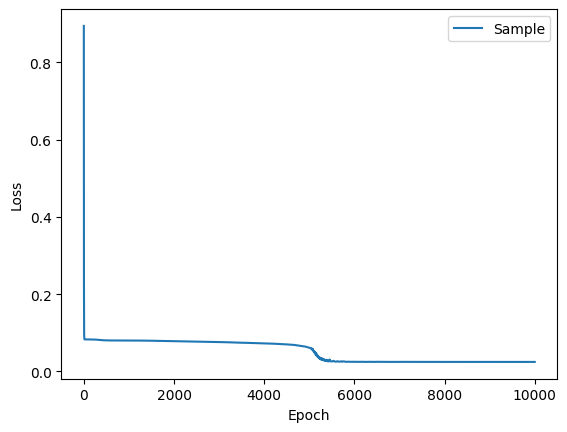

ratio of parameters:
[ 0.18597451  0.7314472  -0.18000886 -1.        ]
Normalized parameters:
[ 1.         0.4601054 -0.4513507 -1.       ]


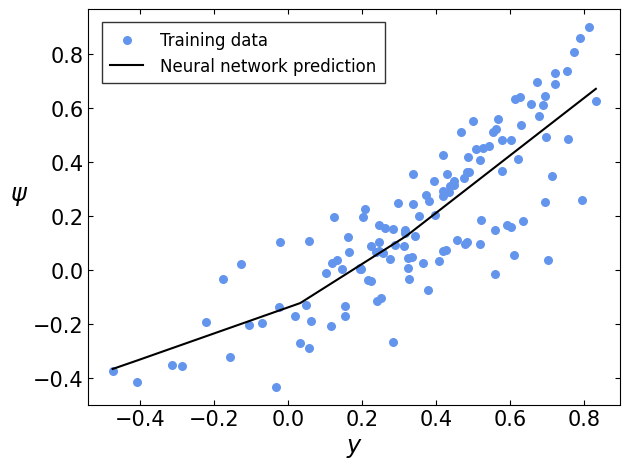

In [ ]:
max_epoch=10000 # The number of the epoch
perform_single(x_ex_data, z_ex_data, max_epoch)

### Estimation of the uncertainty of the learned parameters by the bootstrap method

In [ ]:
max_epoch=10000
num_samples=50
loss_threshold=0.1
perform_bootstrap(x_ex_data, z_ex_data, max_epoch, num_samples, loss_threshold)